<a href="https://colab.research.google.com/github/K-107/exercise/blob/main/Informer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기본적인 인포머 훈련 및 예측

## Download code and dataset

In [1]:
!git clone https://github.com/zhouhaoyi/Informer2020.git
!git clone https://github.com/zhouhaoyi/ETDataset.git
!ls

Cloning into 'Informer2020'...
remote: Enumerating objects: 556, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 556 (delta 9), reused 11 (delta 4), pack-reused 535
Receiving objects: 100% (556/556), 6.48 MiB | 9.82 MiB/s, done.
Resolving deltas: 100% (315/315), done.
Cloning into 'ETDataset'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (184/184), done.
remote: Total 187 (delta 66), reused 13 (delta 2), pack-reused 0
Receiving objects: 100% (187/187), 3.85 MiB | 10.09 MiB/s, done.
Resolving deltas: 100% (66/66), done.
ETDataset  Informer2020  sample_data


In [2]:
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

In [ ]:
# !pip install -r ./Informer2020/requirements.txt

## Experiments: Train and Test

In [3]:
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch

In [4]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'ETTh1' # data
args.root_path = './ETDataset/ETT-small/' # root path of data file
args.data_path = 'ETTh1.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'OT' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 24 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 7 # encoder input size
args.dec_in = 7 # decoder input size
args.c_out = 7 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.do_predict= True # 이걸로 예측한다!
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 6
args.patience = 3
args.des = 'exp'
args.inverse = True # 이걸로 standardscaler 되돌려 놓는다!

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'


In [5]:
print('Args in experiment:')
print(args)

Args in experiment:
{'model': 'informer', 'data': 'ETTh1', 'root_path': './ETDataset/ETT-small/', 'data_path': 'ETTh1.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 24, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'do_predict': True, 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 6, 'patience': 3, 'des': 'exp', 'inverse': True, 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3'}


In [6]:
Exp = Exp_Informer

In [7]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)
    
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()


# 기본 훈련에서는 train,val,test가 train 8521, val 2857, test 2857로 세팅돼있다.

Use GPU: cuda:0
>>>>>>>start training : informer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 8521
val 2857
test 2857
	iters: 100, epoch: 1 | loss: 8.0875025
	speed: 0.2963s/iter; left time: 443.5705s
	iters: 200, epoch: 1 | loss: 4.9170108
	speed: 0.2929s/iter; left time: 409.2235s
Epoch: 1 cost time: 78.41309714317322
Epoch: 1, Steps: 266 | Train Loss: 7.7465969 Vali Loss: 9.8853436 Test Loss: 12.2489147
Validation loss decreased (inf --> 9.885344).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 4.0072536
	speed: 0.6152s/iter; left time: 757.2564s
	iters: 200, epoch: 2 | loss: 5.1443563
	speed: 0.2920s/iter; left time: 330.2034s
Epoch: 2 cost time: 77.5724732875824
Epoch: 2, Steps: 266 | Train Loss: 4.1868692 Vali Loss: 9.4039488 Test Loss: 12.7015715
Validation loss decreased (9.885344 --> 9.403949).  Saving model ...
Updating learning rate to 5e-05
	iters: 100, epoch: 3 | l

## 훈련 결과 Visualization

In [9]:
# When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
# The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)
import numpy as np

preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

# [samples, pred_len, dimensions]
preds.shape, trues.shape

((2848, 24, 7), (2848, 24, 7))

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

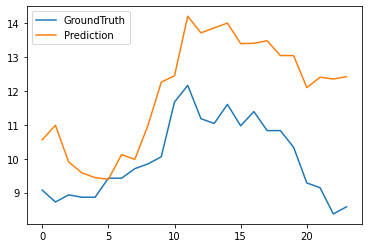

In [18]:
# draw OT prediction
# [:,:,:]의 마지막 요소가 컬럼이다.

plt.figure()
plt.plot(trues[3,:,-1], label='GroundTruth')
plt.plot(preds[3,:,-1], label='Prediction')
plt.legend()
plt.show()

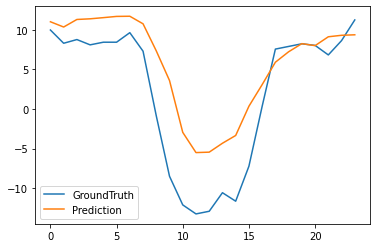

In [26]:
# draw HUFL prediction
plt.figure()
plt.plot(trues[0,:,0], label='GroundTruth')
plt.plot(preds[0,:,0], label='Prediction')
plt.legend()
plt.show()

## 모든 요소 그려보기

In [27]:
preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

# [samples, pred_len, dimensions]
preds.shape, trues.shape

((2848, 24, 7), (2848, 24, 7))

In [29]:
# 뽑아내서 쫙 그려보자.

preds[:,:,0]

array([[11.023375 , 10.358292 , 11.312194 , ...,  9.125521 ,  9.3131   ,
         9.3754015],
       [10.721025 , 12.102805 , 11.037073 , ...,  9.228872 ,  9.359715 ,
         9.564261 ],
       [10.675522 , 10.539898 , 10.745465 , ...,  9.725518 ,  9.8332   ,
        10.034316 ],
       ...,
       [ 8.231481 ,  7.8502765,  8.594279 , ...,  5.9379077,  5.889243 ,
         5.8077717],
       [ 9.26757  ,  8.214096 ,  9.841872 , ...,  5.6211348,  5.5584154,
         5.5371866],
       [ 9.740385 ,  9.493227 , 11.273754 , ...,  5.0976796,  5.144418 ,
         5.25943  ]], dtype=float32)

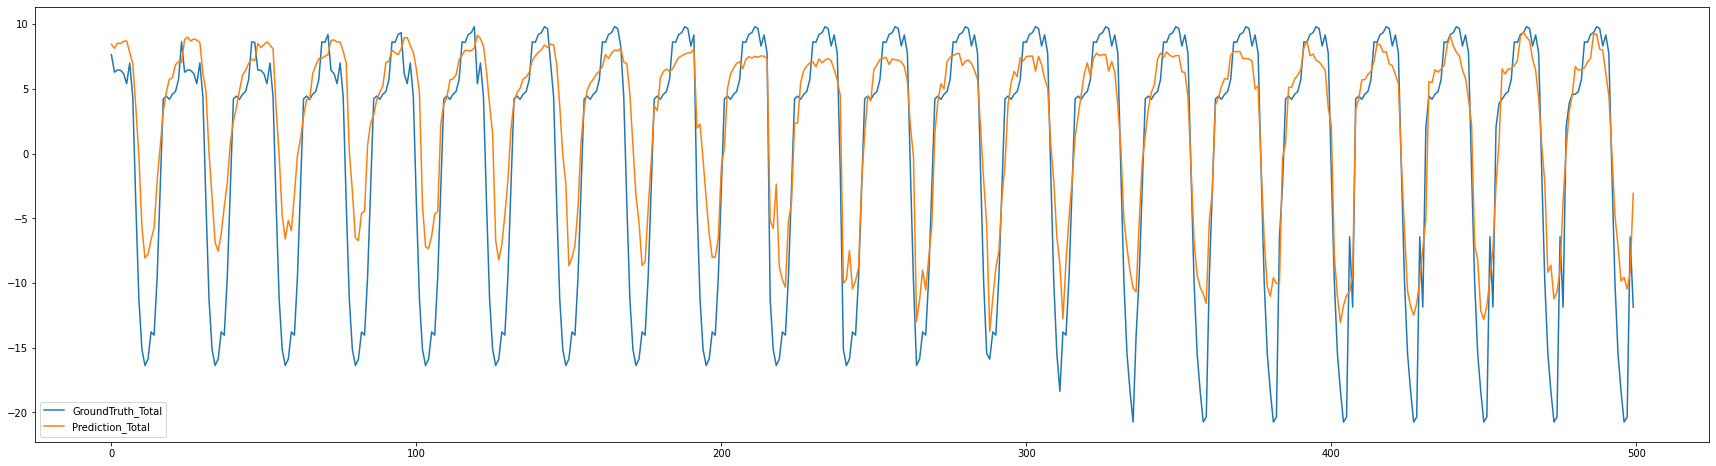

In [43]:
preds_total = preds[:,:,2].reshape(-1)
trues_total = trues[:,:,2].reshape(-1)

plt.figure(figsize=(30,8))
plt.plot(trues_total[:500], label='GroundTruth_Total')
plt.plot(preds_total[:500], label='Prediction_Total')
plt.legend()
plt.show()

## Prediction

### More details about Prediction - prediction dataset

You can give a `root_path` and `data_path` of the data you want to forecast, and set `seq_len`, `label_len`, `pred_len` and other arguments as other Dataset. The difference is that you can set a more detailed freq such as `15min` or `3h` to generate the timestamp of prediction series.

`Dataset_Pred` only has one sample (including `encoder_input: [1, seq_len, dim]`, `decoder_token: [1, label_len, dim]`, `encoder_input_timestamp: [1, seq_len, date_dim]`, `decoder_input_timstamp: [1, label_len+pred_len, date_dim]`). It will intercept the last sequence of the given data (seq_len data) to forecast the unseen future sequence (pred_len data).

## Custom Data

Custom data (xxx.csv) has to include at least 2 features: `date`(format: `YYYY-MM-DD hh:mm:ss`) and `target feature`.


# args.pred_len = 24 # prediction sequence length를 보면

# 24개만 예측가능하므로 ETTh1.csv 마지막 24개를 떼서 테스트 해보자.

In [45]:
from data.data_loader import Dataset_Pred
from torch.utils.data import DataLoader
import pandas as pd
import os

In [47]:
args.root_path = './ETDataset/ETT-small/'
args.data_path = 'ETTh1.csv'

df = pd.read_csv(os.path.join(args.root_path, args.data_path))
df

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


# ETTh1.csv에서 맨 뒤 24개만 뺀 ETTh1_train

In [48]:
ETTh1_train = df[:-24]
ETTh1_train.tail()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
17391,2018-06-25 15:00:00,-8.439,3.885,-11.229,2.132,3.107,1.432,11.607
17392,2018-06-25 16:00:00,-1.206,3.215,-4.833,1.635,2.955,1.279,12.381
17393,2018-06-25 17:00:00,4.622,3.081,1.883,1.635,3.655,1.249,11.467
17394,2018-06-25 18:00:00,8.841,3.550,5.366,1.777,3.472,1.310,11.185
17395,2018-06-25 19:00:00,9.511,2.813,6.183,1.315,3.320,1.097,10.552


In [49]:
save_path = '/content/ETDataset/ETT-small/'
ETTh1_train.to_csv(save_path + 'ETTh1_train.csv', index=False)
pd.read_csv(save_path + 'ETTh1_train.csv').tail()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
17391,2018-06-25 15:00:00,-8.439,3.885,-11.229,2.132,3.107,1.432,11.607
17392,2018-06-25 16:00:00,-1.206,3.215,-4.833,1.635,2.955,1.279,12.381
17393,2018-06-25 17:00:00,4.622,3.081,1.883,1.635,3.655,1.249,11.467
17394,2018-06-25 18:00:00,8.841,3.550,5.366,1.777,3.472,1.310,11.185
17395,2018-06-25 19:00:00,9.511,2.813,6.183,1.315,3.320,1.097,10.552


# ETTh1.csv에서 맨 뒤 24개만 뺀 ETTh1_train에서 뒤에서 96개만으로 만든 ETTh1_train_96.csv

## 반드시 args.seq_len = 96 만큼의 데이터가 있어야한다!

In [50]:
ETTh1_train_96 = pd.read_csv(save_path + 'ETTh1_train.csv')[-96:]
ETTh1_train_96

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
17300,2018-06-21 20:00:00,8.774,2.545,5.579,1.173,3.168,1.036,8.653
17301,2018-06-21 21:00:00,8.172,2.009,5.117,0.497,3.046,1.127,8.371
17302,2018-06-21 22:00:00,8.707,2.545,5.899,1.137,2.863,1.036,8.160
17303,2018-06-21 23:00:00,12.994,4.555,7.427,2.416,4.965,1.432,8.090
17304,2018-06-22 00:00:00,12.860,4.622,7.640,2.523,4.752,1.492,8.231
...,...,...,...,...,...,...,...,...
17391,2018-06-25 15:00:00,-8.439,3.885,-11.229,2.132,3.107,1.432,11.607
17392,2018-06-25 16:00:00,-1.206,3.215,-4.833,1.635,2.955,1.279,12.381
17393,2018-06-25 17:00:00,4.622,3.081,1.883,1.635,3.655,1.249,11.467
17394,2018-06-25 18:00:00,8.841,3.550,5.366,1.777,3.472,1.310,11.185


In [51]:
save_path = '/content/ETDataset/ETT-small/'
ETTh1_train_96.to_csv(save_path + 'ETTh1_train_96.csv', index=False)
pd.read_csv(save_path + 'ETTh1_train_96.csv')

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2018-06-21 20:00:00,8.774,2.545,5.579,1.173,3.168,1.036,8.653
1,2018-06-21 21:00:00,8.172,2.009,5.117,0.497,3.046,1.127,8.371
2,2018-06-21 22:00:00,8.707,2.545,5.899,1.137,2.863,1.036,8.160
3,2018-06-21 23:00:00,12.994,4.555,7.427,2.416,4.965,1.432,8.090
4,2018-06-22 00:00:00,12.860,4.622,7.640,2.523,4.752,1.492,8.231
...,...,...,...,...,...,...,...,...
91,2018-06-25 15:00:00,-8.439,3.885,-11.229,2.132,3.107,1.432,11.607
92,2018-06-25 16:00:00,-1.206,3.215,-4.833,1.635,2.955,1.279,12.381
93,2018-06-25 17:00:00,4.622,3.081,1.883,1.635,3.655,1.249,11.467
94,2018-06-25 18:00:00,8.841,3.550,5.366,1.777,3.472,1.310,11.185


# ETTh2.csv에서 테스트용으로 쓸 맨뒤 24개

In [52]:
ETTh1_test = df[-24:]
ETTh1_test.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
17396,2018-06-25 20:00:00,12.994,3.483,8.457,1.635,4.447,1.249,9.989
17397,2018-06-25 21:00:00,12.458,3.751,8.564,2.132,4.082,1.066,9.989
17398,2018-06-25 22:00:00,13.664,5.023,10.056,3.731,3.777,1.218,9.567
17399,2018-06-25 23:00:00,15.539,5.894,11.762,3.376,3.411,1.188,9.426
17400,2018-06-26 00:00:00,18.152,6.966,12.331,4.264,5.544,1.645,9.708


In [53]:
save_path = '/content/ETDataset/ETT-small/'
ETTh1_test.to_csv(save_path + 'ETTh1_test.csv', index=False)
pd.read_csv(save_path + 'ETTh1_test.csv')

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2018-06-25 20:00:00,12.994000,3.483,8.457000,1.635,4.447,1.249,9.989
1,2018-06-25 21:00:00,12.458000,3.751,8.564000,2.132,4.082,1.066,9.989
2,2018-06-25 22:00:00,13.664000,5.023,10.056000,3.731,3.777,1.218,9.567
3,2018-06-25 23:00:00,15.539000,5.894,11.762000,3.376,3.411,1.188,9.426
4,2018-06-26 00:00:00,18.152000,6.966,12.331000,4.264,5.544,1.645,9.708
5,2018-06-26 01:00:00,16.945999,5.961,11.762000,3.482,5.422,1.645,9.638
6,2018-06-26 02:00:00,17.146999,6.765,11.869000,3.553,5.269,1.736,9.778
7,2018-06-26 03:00:00,17.080000,6.765,11.229000,3.482,5.178,1.645,9.567
8,2018-06-26 04:00:00,15.472000,5.827,10.270000,3.518,5.178,1.675,9.426
9,2018-06-26 05:00:00,15.338000,5.358,9.630000,2.310,5.818,1.736,9.286


## 다시 훈련

In [54]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # 개인 데이터는 custom으로 설정해라.
args.root_path = './ETDataset/ETT-small/' # root path of data file
args.data_path = 'ETTh1_train.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'OT' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 24 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 7 # encoder input size
args.dec_in = 7 # decoder input size
args.c_out = 7 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.do_predict= True # 이걸로 예측한다!
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 6
args.patience = 3
args.des = 'exp'
args.inverse = True # 이걸로 standardscaler 되돌려 놓는다!

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

setting = 'informer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0' 의 setting은 사전 훈련된 모델이고,

exp = Exp(args)으로 돌린다.

In [56]:
################# 이게 없으면 에러난다!!! #################
################# 반드시 꼭 실행!! ########################
args.detail_freq = args.freq
args.freq = args.freq[-1:]

In [57]:
print('Args in Test:')
print(args)

Args in Test:
{'model': 'informer', 'data': 'custom', 'root_path': './ETDataset/ETT-small/', 'data_path': 'ETTh1_train.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 24, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'do_predict': True, 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 6, 'patience': 3, 'des': 'exp', 'inverse': True, 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 'h'}


In [58]:
Exp = Exp_Informer

In [59]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)
    
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_custom_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 12058
val 1717
test 3456
	iters: 100, epoch: 1 | loss: 8.5896845
	speed: 0.2921s/iter; left time: 629.9771s
	iters: 200, epoch: 1 | loss: 6.4661431
	speed: 0.2925s/iter; left time: 601.6918s
	iters: 300, epoch: 1 | loss: 5.1500769
	speed: 0.2917s/iter; left time: 570.8060s
Epoch: 1 cost time: 110.00679898262024
Epoch: 1, Steps: 376 | Train Loss: 7.9581371 Vali Loss: 8.0804367 Test Loss: 9.8107929
Validation loss decreased (inf --> 8.080437).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 5.0623288
	speed: 0.6318s/iter; left time: 1125.2121s
	iters: 200, epoch: 2 | loss: 4.6288114
	speed: 0.2914s/iter; left time: 489.7670s
	iters: 300, epoch: 2 | loss: 4.0109901
	speed: 0.2915s/iter; left time: 460.8170s
Epoch: 2 cost time: 109.56247138977051
Epoch: 2, Steps: 376 | Train Loss: 4.487930

In [61]:
settting = 'informer_custom_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'

In [62]:
preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

# [samples, pred_len, dimensions]
preds.shape, trues.shape

((3456, 24, 7), (3456, 24, 7))

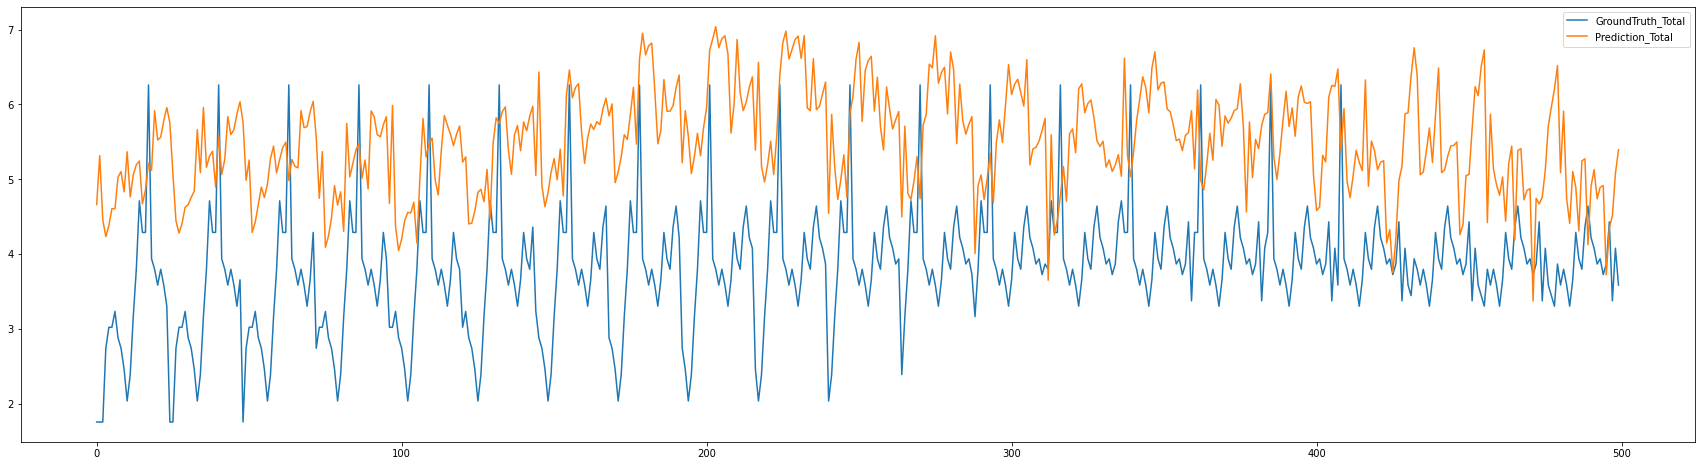

In [70]:
preds_total = preds[:,:,6].reshape(-1)
trues_total = trues[:,:,6].reshape(-1)

plt.figure(figsize=(30,8))
plt.plot(trues_total[:500], label='GroundTruth_Total')
plt.plot(preds_total[:500], label='Prediction_Total')
plt.legend()
plt.show()

### 훈련이 안된다....이상하다...

In [ ]:
# 이걸로 실행해라!!!!
# 걍 여기서 알아서 하는거엿어!!!

from exp.exp_informer import Exp_Informer
Exp = Exp_Informer

exp = Exp(args) 
# exp_informer.py -> class Exp_Informer -> exp_basic.py -> self.model = self._build_model().to(self.device) 
# -> def _build_model -> return model

exp.predict(setting, True)
# def predict -> def _get_data -> 

Use GPU: cuda:0
pred 1


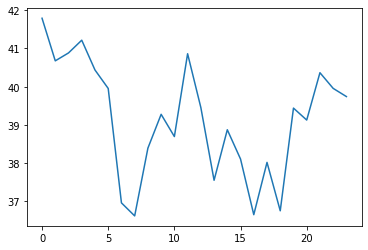

In [ ]:
# ETTh2_train.csv

import numpy as np
import matplotlib.pyplot as plt

real_prediction = np.load('./results/'+setting+'/real_prediction.npy')

plt.figure()
plt.plot(real_prediction[0,:,-1])
plt.show()

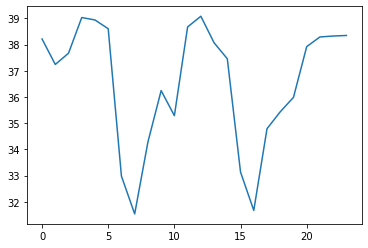

In [ ]:
# ETTh2_train_96.csv로 돌리는 것

import numpy as np
import matplotlib.pyplot as plt

real_prediction = np.load('./results/'+setting+'/real_prediction.npy')

plt.figure()
plt.plot(real_prediction[0,:,-1])
plt.show()

# 데이터가 많으면 좀 더 정확하게 그린다.

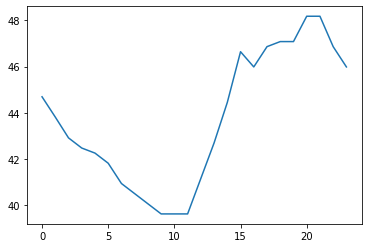

In [ ]:
# 실제 정답

answer = pd.read_csv('/content/ETDataset/ETT-small/ETTh2_test.csv')
plt.figure()
plt.plot(answer.OT)
plt.show()